# Boston Crime Analysis: Pre‑COVID (2019) vs COVID (2020)
### Individual Data Science Project

This notebook analyzes Boston crime data comparing:

- **2019** → Pre-COVID baseline  
- **2020** → COVID shutdown year  

The project follows the IMRaD structure: **Introduction → Methods → Results → Discussion → Summary**.


## 1. Introduction

COVID‑19 changed how people moved, worked, and socialized in Boston. With fewer people commuting, going to bars, or
attending events, we expect crime patterns to shift as well.

### Research Question

> How did reported crime in Boston change from **2019 (pre‑COVID)** to **2020 (during COVID)**?

### Hypothesis

- Total reported crime will be **lower in 2020** than in 2019.  
- Crimes that depend on public activity (for example, property crime) will drop more than others.  
- Time‑of‑day and day‑of‑week patterns will keep a similar shape, but at lower levels in 2020.


## 2. Setup and Imports

Here we import the Python libraries used throughout the analysis:

- **pandas** for data loading and cleaning  
- **numpy** for basic numerical work  
- **matplotlib** and **seaborn** for visualizations


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 150)


## 3. Loading the Data

For this project I use two CSV files:

- `crime_2019.csv` – Boston incidents in 2019  
- `crime_2020.csv` – Boston incidents in 2020

In [10]:
df_2019 = pd.read_csv("crime_2019.csv", low_memory=False)
df_2020 = pd.read_csv("crime_2020.csv", low_memory=False)

print("2019:", df_2019.shape)
print("2020:", df_2020.shape)

df_2019.head()


2019: (87184, 17)
2020: (70894, 17)


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,192017144,3201,NaN,PROPERTY - LOST,D4,167,0,2019-01-01 00:00:00,2019,1,Tuesday,0,NaN,HARRISON AVE,42.334961,-71.075126,"(42.33496089, -71.07512604)"
1,192001553,3201,NaN,PROPERTY - LOST,D4,128,0,2019-01-01 00:00:00,2019,1,Tuesday,0,NaN,STANHOPE ST,42.348689,-71.072580,"(42.34868906, -71.07257996)"
2,192000804,2629,NaN,HARASSMENT,B3,417,0,2019-01-01 00:00:00,2019,1,Tuesday,0,NaN,MORA ST,42.282082,-71.073649,"(42.28208187, -71.07364878)"
3,192065160,619,NaN,LARCENY ALL OTHERS,NaN,,0,2019-01-01 00:00:00,2019,1,Tuesday,0,NaN,BSTN MA,NaN,NaN,NaN
4,192007583,2647,NaN,THREATS TO DO BODILY HARM,C11,393,0,2019-01-01 00:00:00,2019,1,Tuesday,0,NaN,FLORIDA ST,42.287877,-71.058397,"(42.28787659, -71.05839667)"


## 4. Data Cleaning & Feature Engineering


To prepare the data for analysis, I combine the 2019 and 2020 datasets and standardize all column names. The `OCCURRED_ON_DATE` column is converted into a proper datetime format, since the raw files store it as text and are not always consistent. After fixing the dates, I extract new time-based features — **YEAR**, **MONTH**, **HOUR**, and **DAY_OF_WEEK** — directly from the cleaned datetime values. Finally, I filter the dataset to keep only the two years needed for this comparison: **2019 (pre-COVID)** and **2020 (COVID)**.



In [11]:
df_all = pd.concat([df_2019, df_2020], ignore_index=True)

# Standardize column names
df_all.columns = df_all.columns.str.upper()

# Convert date
df_all['OCCURRED_ON_DATE'] = pd.to_datetime(df_all['OCCURRED_ON_DATE'], errors='coerce')
df_all = df_all.dropna(subset=['OCCURRED_ON_DATE']).copy()

# Create time features
df_all['YEAR'] = df_all['OCCURRED_ON_DATE'].dt.year
df_all['MONTH'] = df_all['OCCURRED_ON_DATE'].dt.month
df_all['HOUR'] = df_all['OCCURRED_ON_DATE'].dt.hour
df_all['DAY_OF_WEEK'] = df_all['OCCURRED_ON_DATE'].dt.day_name()

# Filter for 2019 & 2020 only
df = df_all[df_all['YEAR'].isin([2019, 2020])].copy()

df['YEAR'].value_counts().sort_index()


,count
YEAR,
2019,87184
2020,70894


### Crime Category Mapping

To simplify the analysis, I create a new variable called `CRIME_CATEGORY` based on the text in the `OFFENSE_DESCRIPTION` column. Since the raw descriptions include hundreds of unique labels, I map them into broader groups such as **Violent**, **Property**, **Drug**, **Vandalism**, and **PublicOrder**.
This makes it easier to compare how different types of crime changed from 2019 to 2020.


In [12]:
def map_category(desc):
    if not isinstance(desc, str): return "Other"
    d = desc.upper()
    if any(k in d for k in ["ASSAULT","BATTERY","ROBBERY","HOMICIDE"]): return "Violent"
    if any(k in d for k in ["LARCENY","THEFT","BURGLARY","STOLEN"]): return "Property"
    if any(k in d for k in ["DRUG","NARCOTIC"]): return "Drug"
    if any(k in d for k in ["VANDALISM","GRAFFITI"]): return "Vandalism"
    if any(k in d for k in ["DISORDER","TRESPASS","DISTURBANCE","ALCOHOL"]): return "PublicOrder"
    return "Other"

df["CRIME_CATEGORY"] = df["OFFENSE_DESCRIPTION"].apply(map_category)


## 5. Methods

Tools used:
- **pandas** → cleaning, grouping, filtering  
- **numpy** → numeric operations  
- **matplotlib/seaborn** → visualizations  

Analysis steps:
1. Monthly trends  
2. Time-of-day distribution  
3. Day-of-week distribution  
4. Crime category ratios  
5. Heatmaps and KDE density plots (unique advanced visuals)


## 6. Results & Visualizations


### 6.1 Monthly Crime Trends


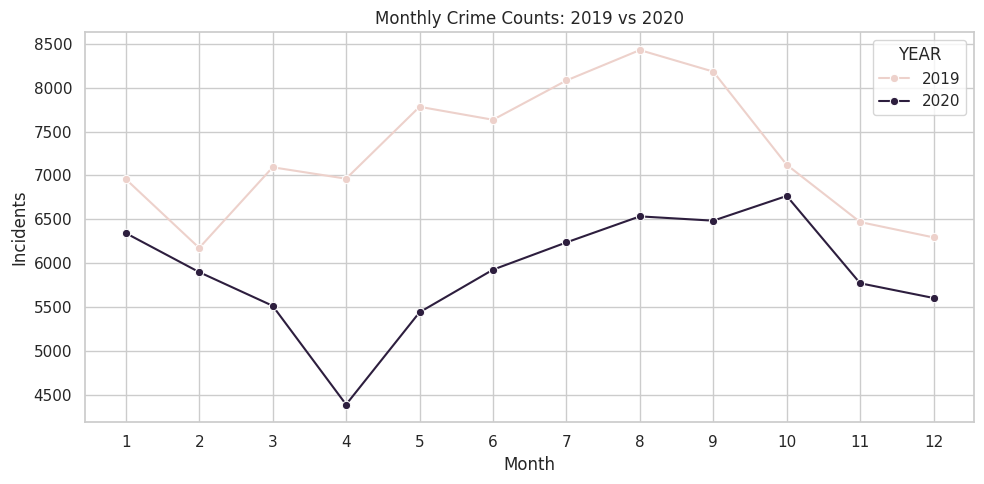

In [13]:
monthly = (
    df.groupby(['YEAR','MONTH'])['INCIDENT_NUMBER']
      .count()
      .reset_index()
)

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly, x='MONTH', y='INCIDENT_NUMBER', hue='YEAR', marker='o')
plt.title("Monthly Crime Counts: 2019 vs 2020")
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


**Interpretation:**  
Crime is lower in every month of 2020 compared to 2019. Both years follow the same pattern (lower in winter, higher in summer), but 2020 never reaches the same peaks. The biggest drop happens around March–May, which matches when COVID shutdowns started.



### 6.2 Heatmap: Crime by Month × Hour (Individual Visualization)


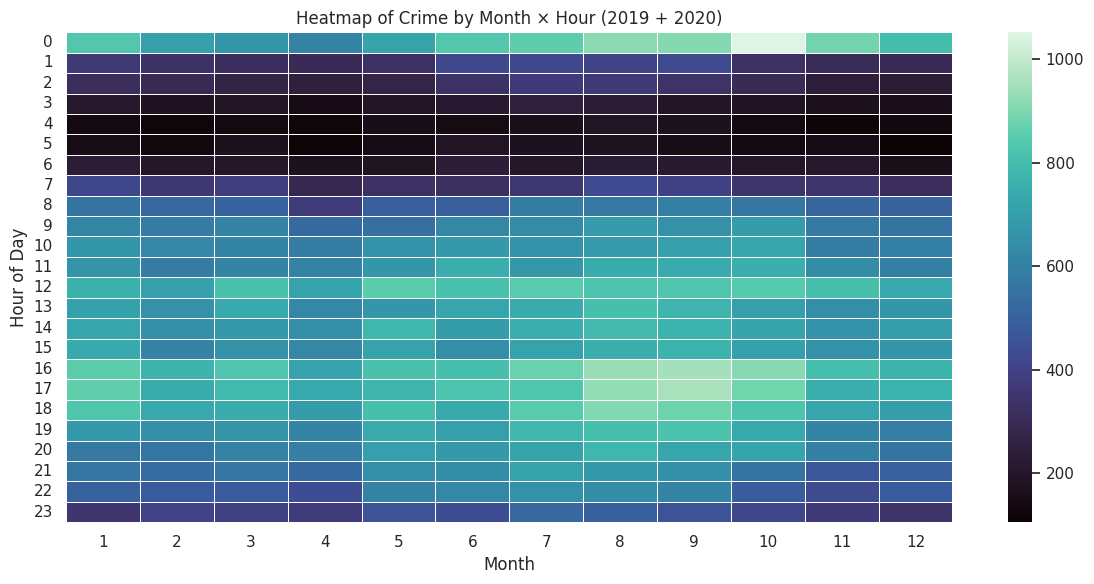

In [14]:
heat_df = (
    df.groupby(['MONTH','HOUR'])['INCIDENT_NUMBER']
      .count()
      .reset_index()
      .pivot(index='HOUR', columns='MONTH', values='INCIDENT_NUMBER')
)

plt.figure(figsize=(12,6))
sns.heatmap(heat_df, cmap='mako', linewidths=.5)
plt.title("Heatmap of Crime by Month × Hour (2019 + 2020)")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()


**Interpretation:**  
This heatmap shows when crime happens the most during the day across the whole year. You can see that crime is pretty low overnight, then starts picking up in the morning, and hits its highest levels from about 3pm–7pm. Summer months (June–August) also look a bit busier overall. The heatmap shows that most crime happens in the afternoon and early evening, not late at night.


### 6.3 Crime Density by Hour of Day (KDE Plot)


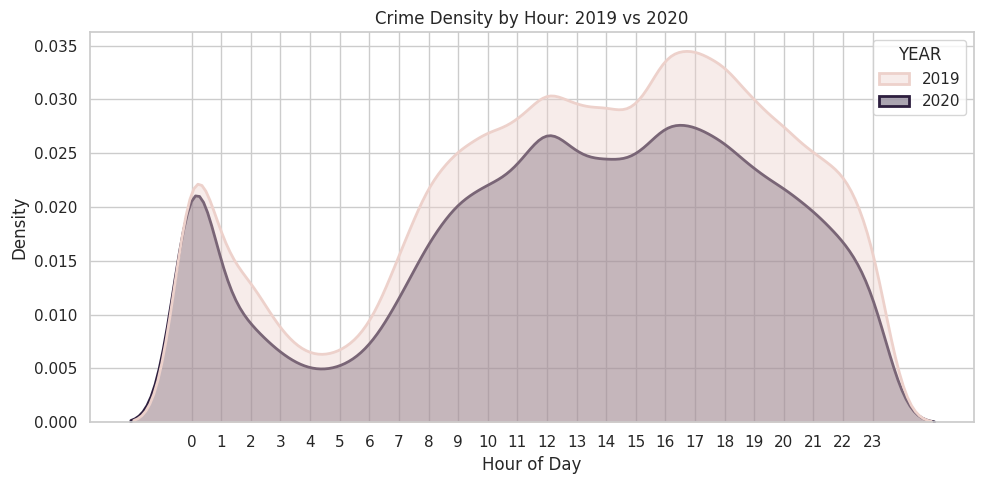

In [15]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x='HOUR', hue='YEAR', fill=True, alpha=0.4, linewidth=2)
plt.title("Crime Density by Hour: 2019 vs 2020")
plt.xlabel("Hour of Day")
plt.ylabel("Density")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


**Interpretation:**  
2020 shows a major collapse in late-night crime due to nightlife shutdowns.


### 6.4 Crime by Day of Week


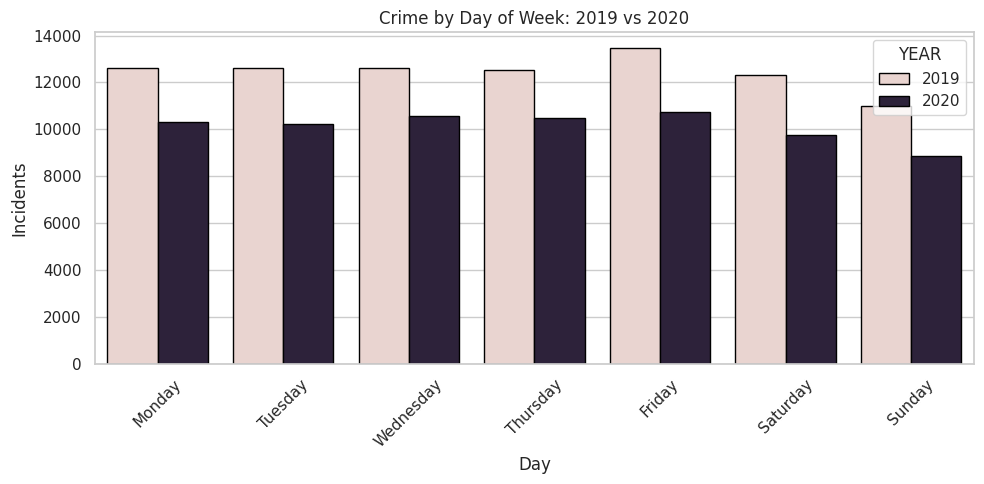

In [16]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

day_counts = (
    df.groupby(['YEAR','DAY_OF_WEEK'])['INCIDENT_NUMBER']
      .count().reset_index()
)

day_counts['DAY_OF_WEEK'] = pd.Categorical(day_counts['DAY_OF_WEEK'], categories=order, ordered=True)
day_counts = day_counts.sort_values(['YEAR','DAY_OF_WEEK'])

plt.figure(figsize=(10,5))
sns.barplot(data=day_counts, x='DAY_OF_WEEK', y='INCIDENT_NUMBER', hue='YEAR', edgecolor='black')
plt.title("Crime by Day of Week: 2019 vs 2020")
plt.xlabel("Day")
plt.ylabel("Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Interpretation:**  
This graph shows how crime is spread out by hour of the day for both years. Both 2019 and 2020 follow almost the exact same pattern: crime is really low overnight, spikes around midnight, dips in the early morning, and then slowly climbs through the day. The busiest hours are the afternoon and early evening. Overall, 2020 is a bit lower across most hours, but the shape of the pattern basically stayed the same.


### 6.5 Violent-to-Property Crime Ratio


In [17]:
cat_sub = df[df['CRIME_CATEGORY'].isin(['Violent','Property'])]

ratio_df = (
    cat_sub.groupby(['YEAR','CRIME_CATEGORY'])['INCIDENT_NUMBER']
            .count()
            .reset_index()
            .pivot(index='YEAR', columns='CRIME_CATEGORY', values='INCIDENT_NUMBER')
)

ratio_df['VIOLENT/PROPERTY'] = ratio_df['Violent'] / ratio_df['Property']
ratio_df


CRIME_CATEGORY,Property,Violent,VIOLENT/PROPERTY
YEAR,,,
2019,13761,8414,0.611438
2020,12642,5183,0.409983


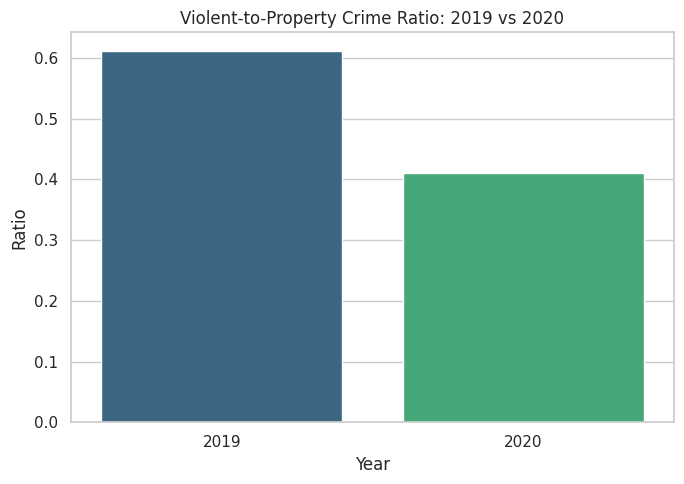

In [19]:
plt.figure(figsize=(7,5))

sns.barplot(
    x=ratio_df.index.astype(str),
    y=ratio_df['VIOLENT/PROPERTY'],
    hue=ratio_df.index.astype(str),   # add a hue
    palette='viridis',
    dodge=False,
    legend=False                      # hide the legend
)

plt.title("Violent-to-Property Crime Ratio: 2019 vs 2020")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.tight_layout()
plt.show()


**Interpretation:**  
This chart shows how common violent crimes were compared to property crimes in each year. In 2019, the ratio was higher, meaning violent crimes made up a larger share of total activity. In 2020, the ratio dropped a lot, which lines up with the idea that property crimes fell less than violent ones during the COVID restrictions. Overall, violent crime became a smaller piece of the crime mix in 2020.


## 7. Discussion

### Key Findings
- **Monthly Crime Trends:** Crime in 2020 drops sharply starting in March, while 2019 stays much higher, showing the immediate impact of COVID shutdowns.
- **Month × Hour Heatmap:** Late-night and afternoon/evening hours show noticeably lower activity, especially in 2020, meaning fewer chances for crime when people stayed home.
- **Hourly Density Plot:** 2020 has a flatter curve with smaller peaks, showing that crime didn’t spike at the usual busy hours like it did in 2019.
- **Violent-to-Property Ratio:** Property crime fell more than violent crime in 2020, which is why the ratio is lower that year.

### Why This Matters
COVID changed daily routines, nightlife, and movement around the city. The drops in crime line up with these behavior changes and match patterns seen in other major U.S. cities.

### Future Research
- Add 2021–2023 to show the rebound after restrictions ended.
- Include mobility or foot-traffic data to connect movement with crime trends.
- Explore forecasting or clustering methods for deeper pattern analysis.


## 8. Summary

### Most Important Findings
- Overall crime was noticeably higher in 2019 than in 2020, with the biggest drop happening right when COVID shutdowns started in March.
- Crime patterns by hour and month show that late-night and busy afternoon hours had much less activity in 2020, likely because people were staying home.
- The hourly density curve shows that the usual crime “peaks” seen in 2019 flatten out in 2020.
- The violent-to-property crime ratio drops in 2020, meaning property crimes fell more sharply than violent crimes.

### Overall Conclusion
The data clearly shows that COVID-19 restrictions had a major impact on Boston’s crime patterns. By reducing nightlife, travel, and daily movement, 2020 saw lower crime across most categories and times of day compared to 2019.
